In [1]:
from typing import Iterable, Optional, Dict
from math import ceil
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer

In [2]:
def peg(qc: QuantumCircuit, q: QuantumRegister, ctrl: int, left: int, mid: int, right: int):
    """
    Single quantum peg as in Fig. 3: cswap(left, mid), CX(mid->ctrl), cswap(mid, right).
    Produces the 50/50 split across left and right when ctrl is in |+>. 
    """
    qc.cswap(q[ctrl], q[left], q[mid])
    qc.cx(q[mid], q[ctrl])
    qc.cswap(q[ctrl], q[mid], q[right])

In [317]:
def build_qgb(
    n_layers: int,
    thetas: Optional[Iterable[float]] = None,
    fine_grained: bool = False,
    measure: bool = True,
) -> QuantumCircuit:
    """
    Quantum Galton Board with n_layers using the 'quantum peg' construction.
    - thetas: optional per-row Rx angles replacing H for bias; len==n_layers.
              If None, uses unbiased H on the control each row. 
    - Output qubits are a 1D line of size (2*n_layers+1). A single '1' propagates
      through the array, yielding the Galton-board statistics on its final position. 
    """
    if n_layers < 1:
        raise ValueError("n_layers >= 1 required")

    L = 2 * n_layers + 1            # number of position sites
    ctrl_idx = 0
    pos_start = 1                   # positions live at q[1..L]
    center = pos_start + n_layers   # middle site index

    q = QuantumRegister(1 + L, "q")
    qc = QuantumCircuit(q, name=f"QGB_{n_layers}")

    # place the 'ball' at the center site (Fig. 3 / Sec. 3.1) 
    qc.x(q[center])
    
    if fine_grained:
        theta_list = list(thetas) if thetas is not None else [None] * (n_layers)*(n_layers+1)/2
        if len(theta_list) != (n_layers)*(n_layers+1)/2:
            raise ValueError("thetas length is not appropiate")
    else:
        theta_list = list(thetas) if thetas is not None else [None] * n_layers
        if len(theta_list) != n_layers:
            raise ValueError("thetas length must equal n_layers")

    if fine_grained:
        indeces = 0
        theta_list_reshape = []
        for k in range(n_layers):
            temp = []
            for i in range(k+1):
                temp.append(theta_list[indeces])
                indeces += 1
            theta_list_reshape.append(temp)
            # print(len(temp))
            
        for r in range(1, n_layers+1):
        # for r1 in range(10):
            row_thetas = list(theta_list_reshape[r-1])
            if len(row_thetas) != r:
                raise ValueError(f"row {r}: need {r} angles, got {len(row_thetas)}")

            
            mids = list(range(center - (r - 1), center + (r - 1) + 1, 2))
            
            # qc.reset(q[ctrl_idx])  # reset control qubit
            for i, m in enumerate(mids):
                qc.reset(q[ctrl_idx])
                qc.rx(row_thetas[i], q[ctrl_idx])
                left, mid, right = m - 1, m, m + 1
                peg(qc, q, ctrl_idx, left, mid, right)
                
                # if i < len(mids) - 2:
                #     qc.cx(q[right], q[ctrl_idx])
                # elif i == len(mids) - 2:
                #     qc.reset(q[ctrl_idx])
                #     qc.rx(row_thetas[-1], q[ctrl_idx])
            qc.barrier()
            for rgt in (m+2 for m in mids[:-1]):
                qc.cx(q[rgt], q[rgt - 1])
                qc.reset(q[rgt])
                

            
            # print(len(row_thetas))
        
    else:
        # iterate rows (Sec. 3.2–3.3). Reset control and prepare coin each row. 
        for r in range(1, n_layers):
            # reset + coin on control for this row (H or Rx for bias; Sec. 5.1) 
            qc.reset(q[ctrl_idx])
            if theta_list[r - 1] is None:
                qc.h(q[ctrl_idx])
            else:
                qc.rx(theta_list[r - 1], q[ctrl_idx])

            # pegs at middle sites spaced by 2 across the row: m = center-(r-1) ... center+(r-1) (step 2)
            mids = list(range(center - (r - 1), center + (r - 1) + 1, 2))
            for i, m in enumerate(mids):
                left, mid, right = m - 1, m, m + 1
                peg(qc, q, ctrl_idx, left, mid, right)
                if i < len(mids) - 1:                       # corrective rebalance before next peg
                    qc.cx(q[right], q[ctrl_idx])  

    # optional measurements of every position site (Sec. 4.1, 4.3) 
    if measure:
        qc.barrier()  # optional barrier before measurement
        c = ClassicalRegister(L, "c")
        qc.add_register(c)
        # map pos q[1..L] -> c[0..L-1] with c[0] the leftmost bin and c[-1] the rightmost
        for i in range(L):
            qc.measure(q[pos_start + i], c[i])

    return qc

In [196]:
def sample_qgb(n_layers: int, shots: int = 20000, thetas: Optional[Iterable[float]] = None) -> Dict[int, int]:
    """
    Run and collapse each shot to a single integer bin k in [0..n_layers].
    We read the measured one-hot position index j in [0..2n] and convert
    to bin k via k = j - n (i.e., how many rights minus lefts, shifted to 0..n). 
    """
    qc = build_qgb(n_layers, thetas=thetas, measure=True)
    backend = Aer.get_backend("aer_simulator")
    res = backend.run(qc, shots=shots, memory=True).result()
    counts = res.get_counts()
    memory = res.get_memory()
    print(counts)
    print(memory)
    # bitstrings are length L with c[0] the leftmost site. Find the '1' position.
    hist: Dict[int, int] = {}
    n = n_layers
    for bitstr, c in counts.items():
        # Aer returns little-endian classical strings; reverse to align c[0]..c[L-1]
        s = bitstr[::-1]
        j = s.index("1")  # exactly one '1' expected on ideal circuit (Sec. 3.4) 
        k = j - n         # map site j∈[0..2n] to bin offset in [-n..+n]
        # classical GB bins are 0..n for number of rights; convert: rights = (k + n)//2
        rights = (k + n) // 2
        hist[rights] = hist.get(rights, 0) + c
    return dict(sorted(hist.items())), memory





In [318]:
# ---------- examples ----------
# Unbiased 20-layer (≈ normal with μ=N/2, σ²=N/4). 
# qc = build_qgb(2, thetas=[np.pi/1, np.pi/2, np.pi/4], fine_grained=True)
# qc = build_qgb(4, thetas=[None for i in range(4)], fine_grained=False, measure=True)
# qc = build_qgb(4, thetas=[np.pi/2 for i in range(4)], fine_grained=False, measure=True)
qc = build_qgb(4, thetas=[np.pi/2 for i in range(10)], fine_grained=True, measure=True)
# print(qc.depth())

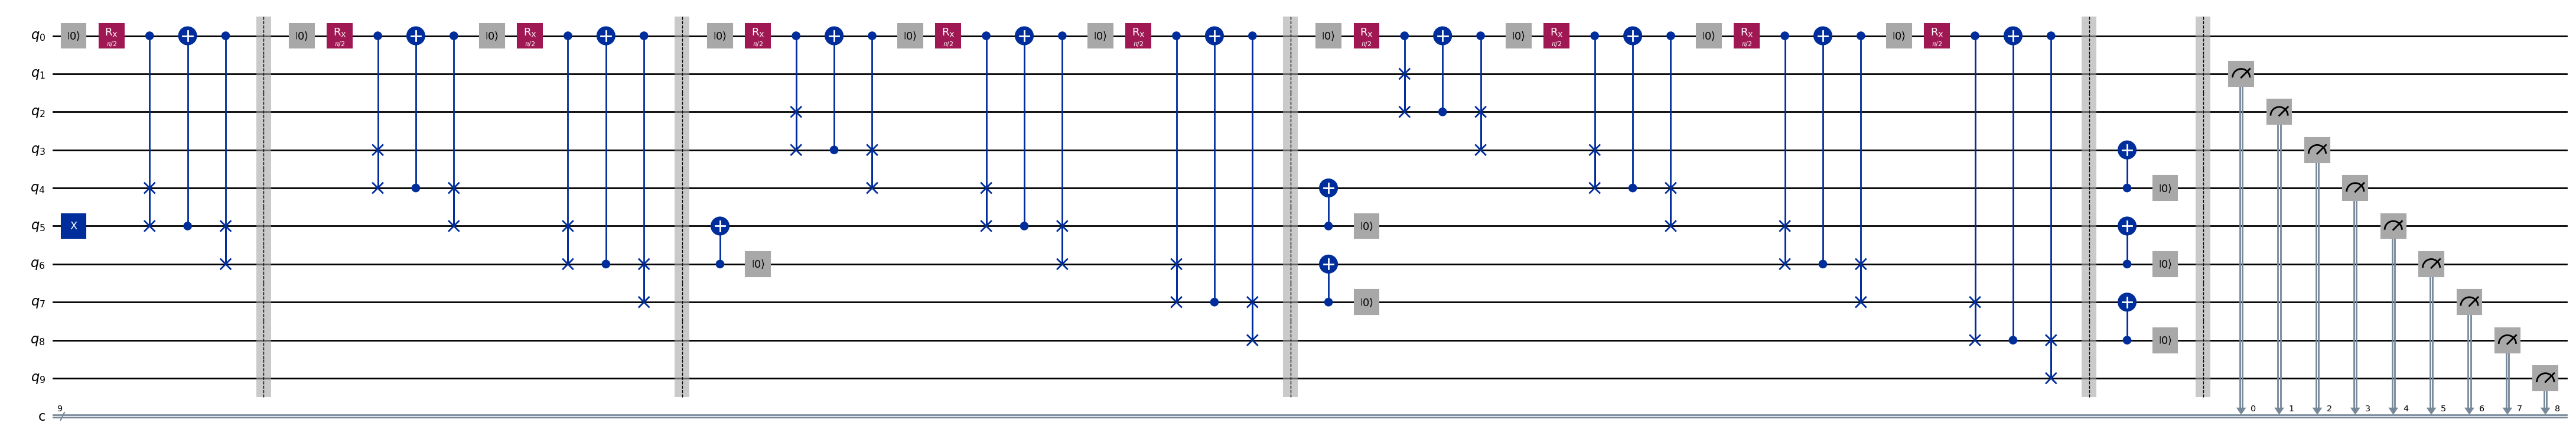

In [319]:
qc.draw(output='mpl', fold=100)

In [166]:
h, mems = sample_qgb(5, shots=80000)


{'00000000001': 2405, '00000010000': 25018, '00100000000': 12475, '00000000100': 12478, '10000000000': 2446, '00001000000': 25178}
['00100000000', '10000000000', '00100000000', '00000010000', '00000000100', '00000010000', '00001000000', '00000000100', '00001000000', '00000000100', '00000010000', '00000000100', '00001000000', '00100000000', '00001000000', '00100000000', '00100000000', '00000010000', '00000000100', '00000010000', '00000010000', '00000010000', '00000000100', '00100000000', '00000000100', '00100000000', '00001000000', '00000010000', '00001000000', '00000010000', '00001000000', '00001000000', '00001000000', '00100000000', '00001000000', '00001000000', '00000010000', '00000010000', '00100000000', '00000010000', '00001000000', '00001000000', '00000010000', '00000010000', '00001000000', '00001000000', '00100000000', '00001000000', '00100000000', '00000010000', '00000010000', '00000000001', '00000000100', '00001000000', '00001000000', '00000010000', '00100000000', '00001000000'

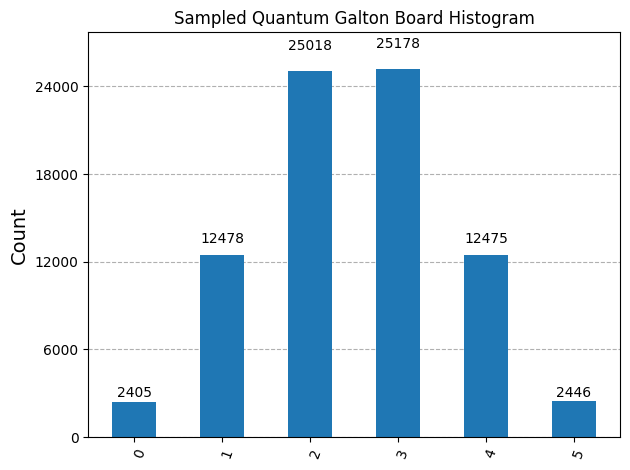

In [176]:
from qiskit.visualization import plot_histogram
plot_histogram(h, title="Sampled Quantum Galton Board Histogram", bar_labels=True)  

In [ ]:
def onehot_to_rights(bitstr: str, n_layers: int) -> int:
    """
    Map a one-hot position over L=2n+1 bits to the classical GB bin 0..n.
    Qiskit memory strings are little-endian; reverse so c[0] is leftmost.
    For an ideal QGB, only even positions are populated, so rights = j//2.
    """
    s = bitstr[::-1]               # align with c[0]..c[L-1]
    j = s.index("1")               # one '1' expected
    return j // 2         

def blocksums(vals, block=8):
    k = len(vals) - (len(vals) % block)  # drop tail
    return [sum(vals[i:i+block]) for i in range(0, k, block)]

def compute_block_sums(N: int, block_size: int, mems: Iterable[str]) -> Dict[int, int]:
    """
    Compute the block sums of one-hot position strings in mems.
    Each string is length L=2N+1, and we sum over blocks of size 8.
    """
    # Convert each one-hot string to the number of rights (0..N)
    # and then compute the block sums.
    from collections import Counter
    per_shot_vals = [onehot_to_rights(b, N) for b in mems]  # each in {0,1,2,...,N}
    block8_sums = blocksums(per_shot_vals, block=block_size)  # each in {0..8N}
    return Counter(block8_sums)
    
hist32 = compute_block_sums(5, block_size=8, mems=mems)



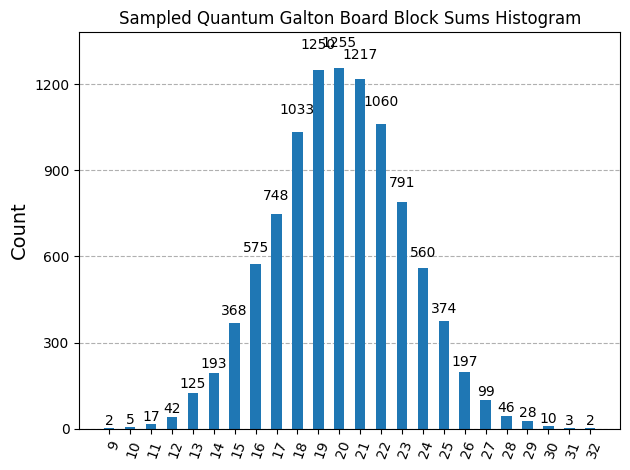

In [179]:
plot_histogram(hist32, title="Sampled Quantum Galton Board Block Sums Histogram")

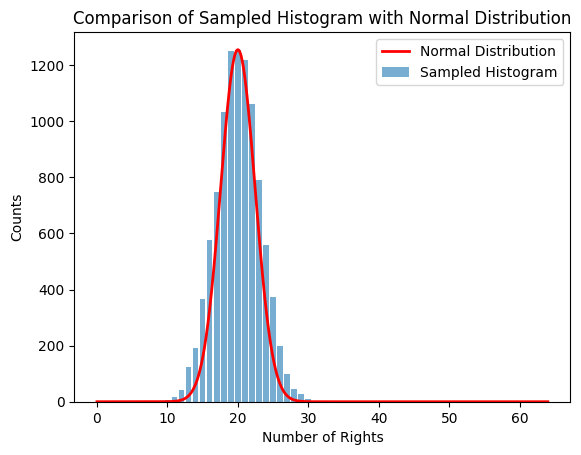

In [180]:
def compare_histogram_with_normal_distribution(hist: Dict[int, int], n_layers: int, shots: int, block_size: int = 8):
    """
    Compare the histogram of sampled rights with a normal distribution.
    """
    import matplotlib.pyplot as plt
    from scipy.stats import norm

    mu = block_size * (n_layers) // 2
    variance = n_layers + 1
    sigma = np.sqrt(variance)
    # print(f"mu={mu}")
    # print(f"variance={variance}")
    # print(f"sigma={sigma}")

    x = np.arange(0, 2**(n_layers + 1), 0.0001)
    max_value_hist = max(hist.values())
    
    
    y = norm.pdf(x, mu, sigma)  # scale to number of shots
    y = y / y.max()
    y = y * (max_value_hist)  # scale to number of shots

    plt.bar(hist.keys(), hist.values(), width=0.8, label='Sampled Histogram', alpha=0.6)
    plt.plot(x, y, 'r-', label='Normal Distribution', linewidth=2)
    plt.xlabel('Number of Rights')
    plt.ylabel('Counts')
    plt.title('Comparison of Sampled Histogram with Normal Distribution')
    plt.legend()
    plt.show()
    
compare_histogram_with_normal_distribution(hist32, N, 80000, block_size=8)

In [182]:
h1, mems1 = sample_qgb(n_layers=5, shots=80000, thetas=[np.pi/2 for i in range(5)])

{'00001000000': 25119, '00000000001': 2485, '00100000000': 12630, '00000010000': 24916, '10000000000': 2475, '00000000100': 12375}
['00001000000', '00000010000', '00001000000', '00001000000', '00001000000', '00100000000', '00000010000', '00001000000', '00000010000', '00001000000', '00000010000', '00001000000', '00000000100', '00001000000', '00000000100', '00000010000', '00100000000', '00100000000', '00000010000', '00000010000', '00000010000', '00000010000', '00001000000', '00001000000', '00001000000', '00000010000', '00001000000', '00000000100', '00100000000', '00000010000', '00100000000', '00001000000', '00000010000', '00100000000', '00001000000', '00100000000', '00001000000', '00100000000', '00001000000', '00100000000', '00000010000', '00100000000', '00000010000', '00000010000', '00000010000', '00000000100', '00000010000', '00000000100', '00000010000', '00000010000', '00001000000', '00001000000', '00000010000', '00000000100', '00000010000', '00100000000', '00100000000', '00000010000'

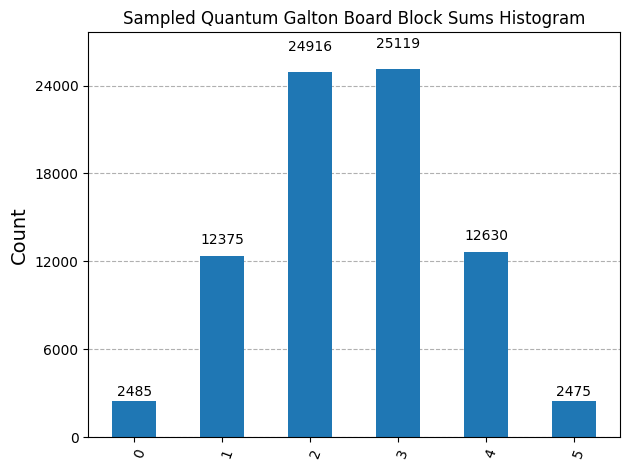

In [183]:
plot_histogram(h1, title="Sampled Quantum Galton Board Block Sums Histogram")

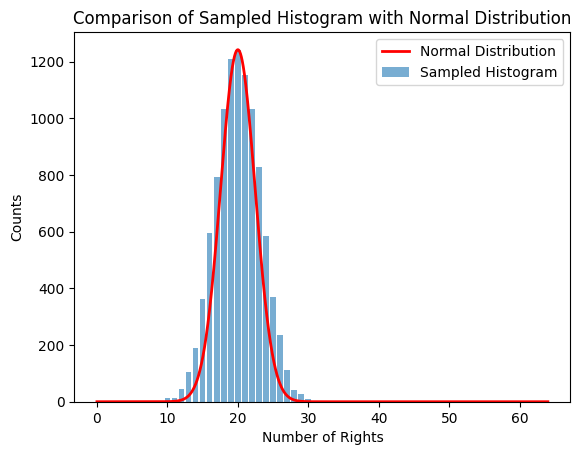

In [184]:
hist32_1 = compute_block_sums(5, block_size=8, mems=mems1)
compare_histogram_with_normal_distribution(hist32_1, 5, 80000, block_size=8)